In [1]:
from parse_truth import main as parse_truth
import collections



datadir = '/home/kyle/data/rnaseq/human/'
froot = 'human'
datafilename = froot + '_gt_not_opt.txt'
datafile = open(datafilename, 'r')

# Given list of gt filename-instancenum pairs, aggregate dictionary:
# key = 'filename instancenum'
# val = ground truth path decomp info (weights and paths)
gt_pathset_dict = parse_truth(datafile, datadir)
datafile.close()


Input list parsed, beginning processing of data
Processing 810, 58...1 repetitions found
Processing 5698, 58...0 repetitions found
Processing 4401, 58...0 repetitions found
Processing 6426, 58...0 repetitions found
Processing 6680, 58...0 repetitions found
Processing 749, 58...1 repetitions found
Processing 4907, 58...1 repetitions found
Processing 5506, 58...0 repetitions found
Processing 6131, 58...1 repetitions found
Processing 6135, 58...1 repetitions found
Processing 6160, 58...0 repetitions found
Processing 9344, 58...1 repetitions found
Processing 1020, 58...0 repetitions found
Processing 1661, 58...0 repetitions found
Processing 4798, 58...1 repetitions found
Processing 406, 58...0 repetitions found
Processing 4875, 58...1 repetitions found
Processing 4966, 58...0 repetitions found
Processing 7324, 58...1 repetitions found
Processing 7401, 58...1 repetitions found
Processing 11295, 58...0 repetitions found
Processing 2010, 58...0 repetitions found
Processing 4885, 58...0 repeti

In [2]:
len(gt_pathset_dict)

431

In [3]:
# Extract solution set from toboggan output

from collections import defaultdict
toboggan_results_file = './data/' + froot + '-master-file.txt'


def toboggan_output_parser(toboggan_results_file, filename_instancenum_dict, verbose=False):
    
    def convert_text_to_path(line):
            text_list = line.strip().split('\t')[1]
            text_list = text_list[1:-1].split(', ')  # omit the brackets and commas
            return list(map(lambda x: int(x), text_list))
        
    # Make dict with key = filename, val = set of instances in that file to check
    key_dict = filename_instancenum_dict.copy()

    solutions = {}
    current_soln_key = None
    paths_found = False
    instance_found = False
    toboggan_path_dict = defaultdict(list)
    toboggan_weight = []
    key_pattern = None

    # iterate over lines to the end of file,
    # checking for instances in instance_set
    with open(toboggan_results_file, 'r') as reader:
        for line in reader:
            # get filename+instancenum info
            if 'File' in line and 'instance' in line and 'name' in line:
                temp_line = line.strip().split()
                key_pattern = temp_line[1] + ' ' + temp_line[3]

            # if key_string in line and instance_found is False:
            if (key_pattern in key_dict) and instance_found is False:
                if verbose: 
                    print("found instance: {}".format(line.strip()))
                    print("\t {}".format(key_pattern))
                current_soln_key = key_pattern
                instance_found = True

            elif instance_found is True:
                if line.startswith("#") and "Solutions:" in line and paths_found is False:
                    if verbose: print("Found solution line")
                    paths_found = True
                if paths_found is True:
                    if 'weight = ' in line:
                        toboggan_weight = int(line.strip().split()[-1])
                    elif'[' in line:
                        path = convert_text_to_path(line)
                        toboggan_path_dict[ tuple(path) ].append(toboggan_weight)
            if 'Finished instance.' in line and (instance_found and paths_found):
                if verbose:
                    print(toboggan_path_dict.keys())
                    print("Instance  {}  solution done.\n".format(key_pattern) )
                    
                solutions[current_soln_key] = {
                                                'unique_paths_set':set( toboggan_path_dict.keys() ),
                                                'decomp':toboggan_path_dict
                                              }
                current_soln_key = None
                key_pattern = None
                instance_found = False
                paths_found = False
                toboggan_path_dict = defaultdict(list)
                toboggan_weight = []
    return solutions



In [4]:
all_toboggan_paths = toboggan_output_parser(toboggan_results_file, gt_pathset_dict, verbose=False)

In [5]:
# [1] Count number of GT that are trivial and repeat
def compute_stats(set_1, set_2):
    n = len(set_1.intersection(set_2))
    return n / float(len(set_1) + len(set_2) - n), n/len(set_1)

num_trivial_repeats = 0
num_repeats = 0
num_different_optimal = 0
jaccard_values = {}
intersect_values = {}
intersect_values_two = {}
intersect_on_optimals = {}


for key, val in gt_pathset_dict.items():
    gt_pathset = val['unique_paths_set']
    if len(gt_pathset) == 1:
        num_trivial_repeats += 1
        continue
    else:
        toboggan_pathset = all_toboggan_paths[key]['unique_paths_set']
        this_jaccard_value, this_intersect = compute_stats(toboggan_pathset, gt_pathset)
        if len(gt_pathset) == len(toboggan_pathset):
            if this_jaccard_value == 1:
                num_repeats += 1
                continue
            num_different_optimal += 1
            intersect_on_optimals[key] = this_intersect
            continue

        else:
            jaccard_values[key] = this_jaccard_value
            intersect_values[key] = this_intersect
            intersect_values_two[key] = len(gt_pathset.intersection(toboggan_pathset))/len(gt_pathset)

# SUMMARIZE RESULTS
import numpy

print('{message:=<{fill}}'.format(message='=', fill='91'))
print("Comparing groundtruth vs optimal paths for " + froot + "\n")
print("{: <80}".format("num instances where k_groundtruth > k_optimal:") + "{:7d}".format(len(gt_pathset_dict)) )
print("{: <80}".format("num trivial instances where gt differs from opt only by repeated paths:") + "{:7d}".format(num_trivial_repeats) )
print("{: <80}".format("num nontrivial instances gt differs from opt only by repeated paths:") + "{:7d}".format(num_repeats) )
print("{: <80}".format("num instances where gt has different paths from opt, but num unique paths = k_opt:") + "{:7d}".format(num_different_optimal) )
# print("{: <86}".format("ave intersection of paths_opt and paths_gt when gt is optimal size:") + "{:5.5f}".format(numpy.mean(list(intersect_on_optimals.values()))) )

print("")
print("{: <80}".format("Number of instances remaining:") + "{:7d}".format(len(gt_pathset_dict) - num_trivial_repeats - num_repeats - num_different_optimal ) )
print("Stats on those:")
print("{: <86}".format("ave jaccard index where gt repeats:") + "{:5.5f}".format(numpy.mean(list(jaccard_values.values()))) )
print("{: <86}".format("ave percent paths_opt contained in paths_gt:") + "{:5.5f}".format(numpy.mean(list(intersect_values.values()))) )
print("{: <86}".format("ave percent paths_gt contained in paths_opt:") + "{:5.5f}".format(numpy.mean(list(intersect_values_two.values()))) )


Comparing groundtruth vs optimal paths for human

num instances where k_groundtruth > k_optimal:                                      431
num trivial instances where gt differs from opt only by repeated paths:              90
num nontrivial instances gt differs from opt only by repeated paths:                 84
num instances where gt has different paths from opt, but num unique paths = k_opt:     27

Number of instances remaining:                                                      230
Stats on those:
ave jaccard index where gt repeats:                                                   0.41354
ave percent paths_opt contained in paths_gt:                                          0.61536
ave percent paths_gt contained in paths_opt:                                          0.49721


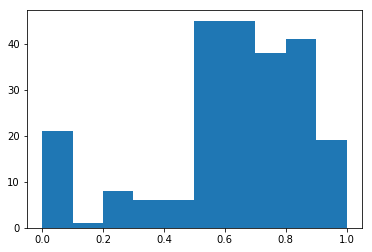

In [6]:
import matplotlib.pyplot as plt

plt.hist(list(intersect_values.values()))
plt.show()

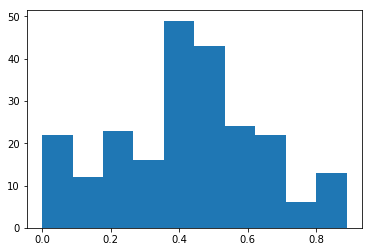

In [7]:
plt.hist(list(jaccard_values.values()))
plt.show()